In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_predict, StratifiedKFold, KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [2]:
score = pd.read_csv('LBLS467-data/score.csv')
srl_motivation = pd.read_csv('LBLS467-data/srl_motivation.csv')
sill = pd.read_csv('LBLS467-data/sill.csv')
srl_strategy = pd.read_csv('LBLS467-data/srl_strategy.csv')
br = pd.read_csv('LBLS467-data/br.csv')
viscode = pd.read_csv('LBLS467-data/viscode.csv')

In [3]:
br.head()

,Unnamed: 0,userid,ADD BOOKMARK,ADD MARKER,ADD MEMO,ADD_HW_MEMO,ADD_RECOMMENDATION,BOOKMARK_JUMP,CHANGE MEMO,CLEAR_HW_MEMO,...,OPEN,OPEN_RECOMMENDATION,PAGE_JUMP,PREV,REGIST CONTENTS,SEARCH,SEARCH_JUMP,UNDO_HW_MEMO,score,class
0,0,019acd030e0cdf674dda03e2a8ca4369,1,81,15,0,0,0,14,0,...,159,0,109,1584,0,0,0,0,70,h
1,1,01ea38c4c3cc5fba869732fc641ca884,7,354,36,1,0,2,22,1,...,256,0,67,750,0,1,0,2,80,a
2,2,023c88ec58c8cf0abcfbcea4166793ad,1,61,25,0,0,0,9,0,...,325,0,7,1275,0,0,0,0,90,a
3,3,02d679ad650962b6ae8bf8adbeeb33c1,4,188,28,8,0,4,25,0,...,138,0,40,788,0,0,0,0,56,c
4,4,0307ea84b89fceab3b507fec1900ce7e,43,464,48,1,0,116,214,0,...,415,0,80,2771,0,0,0,1,80,b


In [4]:
from functools import reduce

dfs = [score, srl_motivation, sill, srl_strategy, br]

def merge_keep_left(left, right):
    right = right[[col for col in right.columns if col not in left.columns or col == "userid"]]
    return pd.merge(left, right, on="userid", how="inner")

merged = reduce(merge_keep_left, dfs)


In [5]:
merged.columns

Index(['userid', 'score', 'class', 'srl_m_1', 'srl_m_2', 'srl_m_3', 'srl_m_4',
       'srl_m_5', 'srl_m_6', 'srl_m_7',
       ...
       'NEXT', 'NOTGETIT', 'OPEN', 'OPEN_RECOMMENDATION', 'PAGE_JUMP', 'PREV',
       'REGIST CONTENTS', 'SEARCH', 'SEARCH_JUMP', 'UNDO_HW_MEMO'],
      dtype='object', length=159)

In [6]:
len(merged)

204

In [7]:
merged['test_anxiety'] = merged[["srl_m_27", "srl_m_28", "srl_m_29",
                      "srl_m_30", "srl_m_31"]].mean(axis=1)



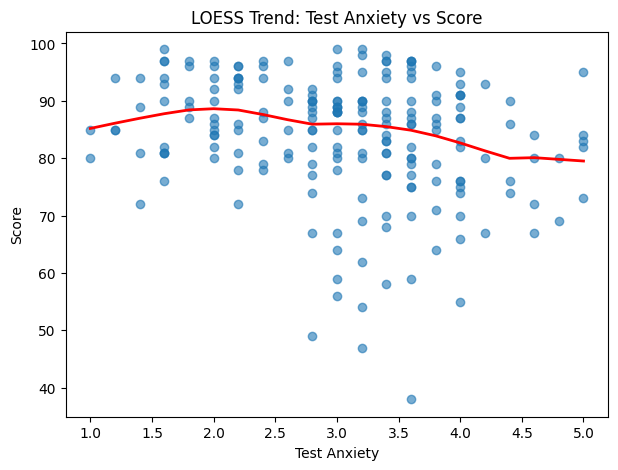

In [12]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

x = merged['test_anxiety']
y = merged['score']

# 使用 LOWESS 平滑
lowess = sm.nonparametric.lowess
z = lowess(y, x, frac=0.3)  # frac越大越平滑（0.2~0.4之間可調）

# 繪圖
plt.figure(figsize=(7,5))
plt.scatter(x, y, alpha=0.6)
plt.plot(z[:,0], z[:,1], color='red', linewidth=2)
plt.title("LOESS Trend: Test Anxiety vs Score")
plt.xlabel("Test Anxiety")
plt.ylabel("Score")
plt.show()


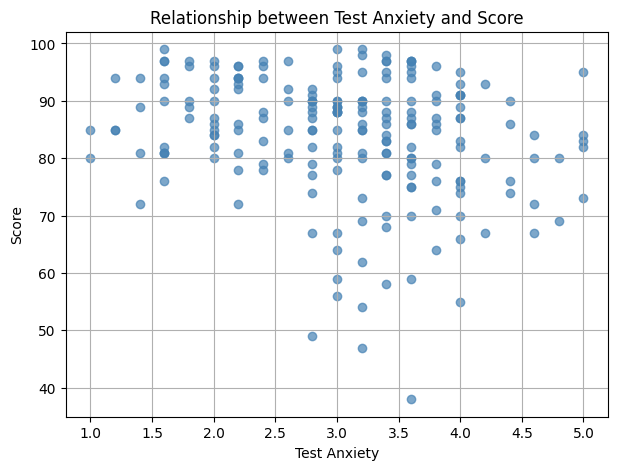

In [7]:
import matplotlib.pyplot as plt

# Basic scatter plot
plt.figure(figsize=(7, 5))
plt.scatter(merged['test_anxiety'], merged['score'], color='steelblue', alpha=0.7)

# Labels and title
plt.xlabel("Test Anxiety")
plt.ylabel("Score")
plt.title("Relationship between Test Anxiety and Score")
plt.grid(True)
plt.show()


In [9]:
X = merged.drop(["userid","class","score",'Unnamed: 0'], axis=1)  
y = merged["score"]

In [10]:
merged.corr(numeric_only=True)["score"].sort_values(ascending=False)

score                 1.000000
srl_m_19              0.425210
srl_m_23              0.396347
srl_m_24              0.356284
srl_m_22              0.354662
                        ...   
s_44                 -0.202610
srl_m_30             -0.228294
srl_m_27             -0.286955
ADD_RECOMMENDATION         NaN
REGIST CONTENTS            NaN
Name: score, Length: 157, dtype: float64

In [11]:
from sklearn.model_selection import cross_val_score
rf = RandomForestRegressor(n_estimators=200, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
all_preds = np.zeros(len(y))
rmse_list = []
feature_importances = []
for train_idx, val_idx in cv.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model = RandomForestRegressor(n_estimators=200, random_state=42)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_val)
            all_preds[val_idx] = y_pred

            rmse = rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            rmse_list.append(rmse)
            feature_importances.append(model.feature_importances_)

print("Cross-validation RMSE scores:", rmse_list)
print("Mean RMSE:", np.mean(rmse_list))


Cross-validation RMSE scores: [np.float64(7.5408888248198345), np.float64(9.408205811171747), np.float64(11.061085406317666), np.float64(11.327863957042752), np.float64(8.271810072469027)]
Mean RMSE: 9.521970814364204


In [17]:
feature_importances = np.array(feature_importances)
mean_importance = feature_importances.mean(axis=0)
std_importance = feature_importances.std(axis=0)

feat_imp_cv = pd.DataFrame({
    "Feature": X.columns,
    "MeanImportance": mean_importance,
    "StdImportance": std_importance
}).sort_values("MeanImportance", ascending=False)

print(feat_imp_cv)

# # Plot
# plt.figure(figsize=(10,6))
# plt.barh(feat_imp_cv["Feature"], feat_imp_cv["MeanImportance"],
#          xerr=feat_imp_cv["StdImportance"])
# plt.gca().invert_yaxis()
# plt.xlabel("Mean Feature Importance (±1 std)")
# plt.title("Random Forest Feature Importance (Cross-Validation)")
# plt.show()


                 Feature  MeanImportance  StdImportance
22              srl_m_23        0.087671       0.021431
18              srl_m_19        0.081374       0.058591
137                CLOSE        0.049505       0.015876
135          CHANGE MEMO        0.038344       0.012388
149            PAGE_JUMP        0.026662       0.009318
..                   ...             ...            ...
136        CLEAR_HW_MEMO        0.000505       0.000240
148  OPEN_RECOMMENDATION        0.000015       0.000030
143           LINK_CLICK        0.000005       0.000008
133   ADD_RECOMMENDATION        0.000000       0.000000
151      REGIST CONTENTS        0.000000       0.000000

[155 rows x 3 columns]


## Features Proxy (for f(features))

In [36]:
def pca_weighted_score(scaled_df, features):
    """
    use PCA to determine weights for given features and compute a weighted score
    """
    
    pca = PCA(n_components=1)
    pca.fit(scaled_df[features])
    
    # use absolute values of loadings as weights
    loadings = np.abs(pca.components_[0])
    weights = loadings / loadings.sum()
    
    # calculate weighted score
    scores = scaled_df[features].values @ weights
    return scores * 100, dict(zip(features, weights))

def init_states(df):
    """
    Calculate features parameters: Intrinsic, Test Anxiety, Task Value, Metacognitive
    """
    # Intrinsic proxies
    intrinsic_features = ["srl_m_1", "srl_m_2", "srl_m_3", 
                      "srl_m_4"]
    
    # Metacognitive proxies
    metacognitive_features = ["s_28", "s_29", "s_30", 
                      "s_31", "s_32", "s_33", "s_34", "s_35", "s_36"]
    
    # Task Value proxies
    task_value_features = ["srl_m_9", "srl_m_10", "srl_m_11",
                      "srl_m_12", "srl_m_13", "srl_m_14"]
    
    # Test Anxiety proxies
    test_anxiety_features = ["srl_m_27", "srl_m_28", "srl_m_29",
                      "srl_m_30", "srl_m_31"]
    
    all_features = intrinsic_features + metacognitive_features + task_value_features + test_anxiety_features
    scaler = MinMaxScaler()
    scaled_all = scaler.fit_transform(df[all_features])
    scaled_df = pd.DataFrame(scaled_all, columns=all_features, index=df.index)
    
    # pca weighted scores for each parameter
    intrinsic, intrinsic_w = pca_weighted_score(scaled_df, intrinsic_features)
    metacognitive, metacognitive_w = pca_weighted_score(scaled_df, metacognitive_features)
    task_value, task_value_w = pca_weighted_score(scaled_df, task_value_features)
    test_anxiety, test_anxiety_w = pca_weighted_score(scaled_df, test_anxiety_features)
    
    # return results and weights
    states = pd.DataFrame({
        "Intrinsic": intrinsic,
        "Metacognitive": metacognitive,
        "Task_value": task_value,
        "Test_anxiety": test_anxiety
    }, index=df.index)
    
    weights = {
        "Intrinsic": intrinsic_w,
        "Metacognitive": metacognitive_w,
        "Task_value": task_value_w,
        "Test_anxiety": test_anxiety_w
    }
    
    return states, weights

## Nudging Iteration

### With double For-loop

In [33]:
def nudging_iteration(X, y, X_states, n_rounds=5, n_splits=5):
    """
    Run iterative nudging simulation.
    - X: Training features
    - X_states: DataFrame with Skill, Motivation, Fatigue
    - y: ground truth labels
    - n_rounds: number of iterations
    - n_splits: number of CV splits for baseline prediction
    """
    current_y = y.copy()
    results = []
    
    for t in range(n_rounds):
        # baseline prediction with CV
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        all_preds = np.zeros(len(current_y))
        rmses = []
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = current_y.iloc[train_idx], current_y.iloc[val_idx]

            rf = RandomForestRegressor(n_estimators=200, random_state=42)
            rf.fit(X_train, y_train)

            y_pred_val = rf.predict(X_val)
            all_preds[val_idx] = y_pred_val

            # RMSE
            mse = mean_squared_error(y_val, y_pred_val)
            rmses.append(np.sqrt(mse))

        residuals = current_y.values - all_preds
        sigma = np.std(residuals)
        mean_rmse = np.mean(rmses)

        # fit linear regression to estimate f(features)
        X_fit = pd.DataFrame({
        "Intrinsic": X_states["Intrinsic"].values,
        "Metacognitive": X_states["Metacognitive"].values,
        "Task_value": X_states["Task_value"].values,
        "Test_anxiety": X_states["Test_anxiety"].values,  
        }, index=X_states.index)
    
        reg = LinearRegression()
        reg.fit(X_fit, current_y)

        X_pred = X_fit.copy()
        f_values = reg.predict(X_pred)
        f_centered = f_values - f_values.mean()
        
        # do(N)
        do_N = np.random.normal(loc=f_centered, scale=sigma)
        
        # nudge rating
        direction = np.sign(all_preds - current_y)  # directional nudging
        do_N = np.abs(do_N) * direction
        nudge_rating = current_y + do_N
        # nudge_rating = np.clip(np.round(nudge_rating), 1, 4)

        current_y = pd.Series(nudge_rating, index=y.index)

        # distances
        results.append({
            "round": t+1,
            "cv_rmse": mean_rmse,
            "mean_dist_nudge": np.mean(np.abs(current_y - all_preds)),
            "mean_dist_true": np.mean(np.abs(y - all_preds)),
            "mean_current_y": current_y.mean(),
            "mean_all_preds": all_preds.mean()
        })
        
        print(f"[Round {t+1}] CV RMSE={mean_rmse:.4f}, "
              f"mean nudged_y={current_y.mean():.3f}, "
              f"dist to preds={np.mean(np.abs(current_y - all_preds)):.4f}")
        
        # save the final model if needed
        final_model = RandomForestRegressor(n_estimators=200, random_state=42)
        final_model.fit(X, current_y)

    return results, current_y, final_model

### With cross-val-predict

In [218]:
def single_nudging_iteration(X, y, X_states, n_rounds=5, n_splits=5, plot_each_round=False):
    """
    Run iterative nudging simulation.
    - X: Training features
    - X_states: DataFrame with Skill, Motivation, Fatigue
    - y: ground truth labels
    - n_rounds: number of iterations
    - n_splits: number of CV splits for baseline prediction
    """
    current_y = y.copy()
    results = []
    pred_history = []
    individual = []
    f_values_his = []
    nudged_history = []
    f_values_baseline = None
    add_memo_history =[]
    
    for t in range(n_rounds):
        # baseline prediction with CV
        rf = RandomForestRegressor(n_estimators=200, random_state=42)
        all_preds = cross_val_predict(rf, X, current_y, cv=n_splits)
        pred_history.append(all_preds.copy())
        
        
        # CV RMSE
        mse = mean_squared_error(current_y, all_preds)
        mean_rmse = np.sqrt(mse)


        residuals = current_y.values - all_preds
        sigma = np.std(residuals)

        # fit linear regression to estimate f(features)
        X_fit = X_states[['ADD MEMO']]
    
        reg = LinearRegression()
        reg.fit(X_fit, current_y)

        X_pred = X_fit.copy()
        f_values = reg.predict(X_pred)
        if f_values_baseline is None:
            f_values_baseline = f_values.copy()
        f_centered = f_values - f_values.mean()
        f_values_his.append(f_values.copy())
        
        # do(N)
        do_N = np.random.normal(loc=f_centered, scale=0.5)
        
        # nudge rating
        direction = np.sign(all_preds - current_y)  # directional nudging
        do_N = np.abs(do_N) * direction
        nudge_rating = current_y + do_N

        # Behavior change based on prediction (ADD MEMO)
        new_add_memo = X_states["ADD MEMO"].astype(float).copy()
        new_add_memo[all_preds < 80] *= 1.1
        new_add_memo[all_preds >= 80] *= 0.9
        new_add_memo = np.round(new_add_memo).astype(int)

        # update back to X_states and X
        X_states.loc[:, "ADD MEMO"] = np.clip(new_add_memo, 0, 140)
        X["ADD MEMO"] = X_states["ADD MEMO"]
        add_memo_history.append(X_states["ADD MEMO"].copy())

        current_y = pd.Series(nudge_rating, index=y.index)
        nudged_history.append(current_y.copy())
        individual.append(current_y[0].copy())

        # distances
        results.append({
            "round": t+1,
            "cv_rmse": mean_rmse,
            "mean_dist_nudge": np.mean(np.abs(current_y - all_preds)),
            "mean_dist_true": np.mean(np.abs(y - all_preds)),
            "mean_current_y": current_y.mean(),
            "mean_all_preds": all_preds.mean()
        })

        
        print(f"[Round {t+1}] CV RMSE={mean_rmse:.4f}, "
              f"mean nudged_y={current_y.mean():.3f}, "
              f"dist to preds={np.mean(np.abs(current_y - all_preds)):.4f}")
        
        if plot_each_round:
            sort_idx = np.argsort(f_values)
            plt.figure(figsize=(8,6))
            plt.scatter(f_values_baseline[sort_idx], y.iloc[sort_idx], color="grey", alpha=0.5, label="Original y")
            plt.scatter(f_values[sort_idx], current_y.iloc[sort_idx], color="red", alpha=0.5, label=f"Nudged y (round {t+1})")
            plt.scatter(f_values[sort_idx], all_preds[sort_idx], color="blue", alpha=0.5, label=f"Prediction (round {t+1})")
            # plt.scatter(f_values[sort_idx], current_y.iloc[sort_idx], color="red", alpha=0.5, label=f"Nudged y (round {t+1})")
            # plt.plot(f_values[sort_idx], all_preds[sort_idx], "k-", linewidth=2, label="Prediction line")
            plt.xlabel("f_value")
            plt.ylabel("Outcome / Prediction")
            plt.title(f"Nudging Iteration {t+1}")
            plt.legend()
            plt.grid(True)
            plt.show()
        
    # save the final model if needed
    final_model = RandomForestRegressor(n_estimators=200, random_state=42)
    final_model.fit(X, current_y)

    return results, y, final_model, f_values_his, pred_history, nudged_history, individual, add_memo_history

In [219]:
# initialization
test_agents = X.copy()

X_states = X[['ADD MEMO']]

# 5 iterations
results, nudged_y, final_model, behavior_his, pred_history, nudged_history, individual, add_memo_history = single_nudging_iteration(test_agents, y, X_states, n_rounds=20, n_splits=5, plot_each_round=False)

[Round 1] CV RMSE=10.2902, mean nudged_y=83.581, dist to preds=6.9844
[Round 2] CV RMSE=9.6892, mean nudged_y=83.468, dist to preds=6.4814
[Round 3] CV RMSE=9.2959, mean nudged_y=83.345, dist to preds=6.1707
[Round 4] CV RMSE=8.9226, mean nudged_y=83.277, dist to preds=5.7687
[Round 5] CV RMSE=8.6551, mean nudged_y=83.229, dist to preds=5.4456
[Round 6] CV RMSE=8.3184, mean nudged_y=83.051, dist to preds=5.0686
[Round 7] CV RMSE=8.0167, mean nudged_y=82.720, dist to preds=4.6246
[Round 8] CV RMSE=7.3845, mean nudged_y=82.395, dist to preds=4.1721
[Round 9] CV RMSE=7.0594, mean nudged_y=81.931, dist to preds=3.6817
[Round 10] CV RMSE=6.5622, mean nudged_y=81.518, dist to preds=3.4292
[Round 11] CV RMSE=6.1859, mean nudged_y=81.238, dist to preds=2.9059
[Round 12] CV RMSE=5.5324, mean nudged_y=80.819, dist to preds=2.7882
[Round 13] CV RMSE=5.2835, mean nudged_y=80.491, dist to preds=2.4481
[Round 14] CV RMSE=4.7169, mean nudged_y=79.992, dist to preds=2.1880
[Round 15] CV RMSE=4.2077, m

In [241]:
def nudging_iteration(X, y, attribute, n_rounds=5, n_splits=5, plot_each_round=False):
    """
    Run iterative nudging simulation.
    - X: Training features
    - attribute: DataFrame single attribute for nudging
    - y: ground truth labels
    - n_rounds: number of iterations
    - n_splits: number of CV splits for baseline prediction
    """
    current_y = y.copy()
    results = []
    pred_history = []
    individual = []
    behavior_his = []
    nudged_history = []

    # behavior_name = attribute.columns[0]
    behavior = attribute
    behavior_baseline = behavior.copy()
    behavior_centered = behavior - np.mean(behavior)
    threshold = 80 
    
    for t in range(n_rounds):
        # baseline prediction with CV
        rf = RandomForestRegressor(n_estimators=200, random_state=42)
        all_preds = cross_val_predict(rf, X, current_y, cv=n_splits)
        pred_history.append(all_preds.copy())
        
        
        # CV RMSE
        mse = mean_squared_error(current_y, all_preds)
        mean_rmse = np.sqrt(mse)


        residuals = current_y.values - all_preds
        sigma = 0.1
        
        # do(N)
        do_N = np.random.normal(loc=behavior_centered, scale=sigma)

        # Rule-based adjustment
        for i in range(len(do_N)):
            if all_preds[i] > threshold:
                do_N[i] *= 0.8  # higher than 80 -> less nudge
            else:
                do_N[i] *= 1.2   # lower than 80 -> more nudge
        
        # nudge rating
        # direction = np.where(all_preds < threshold, 1, -1) 
        # magnitude = np.abs(all_preds - threshold) / 100
        direction = np.sign(all_preds - current_y)  # directional nudging
        do_N = np.abs(do_N) * direction

        nudge_rating = current_y + do_N
        nudge_rating = np.clip(nudge_rating, 1, 100)
        current_y = pd.Series(nudge_rating, index=y.index)
        nudged_history.append(current_y.copy())
        individual.append(current_y[0].copy())

        # distances
        results.append({
            "round": t+1,
            "cv_rmse": mean_rmse,
            "mean_dist_nudge": np.mean(np.abs(current_y - all_preds)),
            "mean_dist_true": np.mean(np.abs(y - all_preds)),
            "mean_current_y": current_y.mean(),
            "mean_all_preds": all_preds.mean()
        })

        
        print(f"[Round {t+1}] CV RMSE={mean_rmse:.4f}, "
              f"mean nudged_y={current_y.mean():.3f}, "
              f"dist to preds={np.mean(np.abs(current_y - all_preds)):.4f}")
        
        if plot_each_round:
            sort_idx = np.argsort(behavior)
            plt.figure(figsize=(8,6))
            plt.scatter(behavior_baseline[sort_idx], y.iloc[sort_idx], color="grey", alpha=0.5, label="Original y")
            plt.scatter(behavior[sort_idx], current_y.iloc[sort_idx], color="red", alpha=0.5, label=f"Nudged y (round {t+1})")
            plt.scatter(behavior[sort_idx], all_preds[sort_idx], color="blue", alpha=0.5, label=f"Prediction (round {t+1})")
            # plt.scatter(behavior[sort_idx], current_y.iloc[sort_idx], color="red", alpha=0.5, label=f"Nudged y (round {t+1})")
            # plt.plot(behavior[sort_idx], all_preds[sort_idx], "k-", linewidth=2, label="Prediction line")
            plt.xlabel("ADD MEMO")
            plt.ylabel("SCORE")
            plt.title(f"Nudging Iteration {t+1}")
            plt.legend()
            plt.grid(True)
            plt.show()
        behavior_his.append(behavior.copy())
        
    # save the final model if needed
    final_model = RandomForestRegressor(n_estimators=200, random_state=42)
    final_model.fit(X, current_y)

    return results, y, final_model, behavior_his, pred_history, nudged_history, individual

## Iteration

In [242]:
# initialization
test_agents = X.copy()
X_states = X['ADD MEMO']

# 5 iterations
results, nudged_y, final_model, behavior_his, pred_history, nudged_history, individual = nudging_iteration(X, y, X_states, n_rounds=20, n_splits=5, plot_each_round=False)

[Round 1] CV RMSE=10.2902, mean nudged_y=79.857, dist to preds=7.8898
[Round 2] CV RMSE=10.0582, mean nudged_y=81.971, dist to preds=7.1524
[Round 3] CV RMSE=9.3708, mean nudged_y=79.753, dist to preds=6.5011
[Round 4] CV RMSE=9.5585, mean nudged_y=82.017, dist to preds=6.0764
[Round 5] CV RMSE=10.2025, mean nudged_y=79.894, dist to preds=6.0582
[Round 6] CV RMSE=8.7419, mean nudged_y=81.522, dist to preds=6.4451
[Round 7] CV RMSE=10.1221, mean nudged_y=79.400, dist to preds=6.1267
[Round 8] CV RMSE=10.0274, mean nudged_y=80.181, dist to preds=6.1887
[Round 9] CV RMSE=10.3588, mean nudged_y=78.076, dist to preds=6.5847
[Round 10] CV RMSE=11.6190, mean nudged_y=79.064, dist to preds=6.1820
[Round 11] CV RMSE=10.1152, mean nudged_y=76.952, dist to preds=6.5553
[Round 12] CV RMSE=12.2349, mean nudged_y=76.048, dist to preds=6.4760
[Round 13] CV RMSE=13.5503, mean nudged_y=73.284, dist to preds=6.8348
[Round 14] CV RMSE=16.8198, mean nudged_y=74.517, dist to preds=6.3097
[Round 15] CV RMSE

In [158]:
def no_nudging_iteration(X, y, X_states, n_rounds=5, n_splits=5, plot_each_round=False):
    """
    Baseline simulation without nudging (y is fixed).
    - X: Training features
    - y: ground truth labels
    - X_states: DataFrame with Skill, Motivation, Fatigue
    """
    results = []
    pred_history = []
    f_values_his = []

    for t in range(n_rounds):
        # baseline prediction with CV
        rf = RandomForestRegressor(n_estimators=200, random_state=42)
        all_preds = cross_val_predict(rf, X, y, cv=n_splits)
        pred_history.append(all_preds.copy())

        # CV RMSE
        mse = mean_squared_error(y, all_preds)
        mean_rmse = np.sqrt(mse)

        # fit linear regression to estimate f(features)
        X_fit = pd.DataFrame({
        "Intrinsic": X_states["Intrinsic"].values,
        "Metacognitive": X_states["Metacognitive"].values,
        "Task_value": X_states["Task_value"].values,
        "Test_anxiety": X_states["Test_anxiety"].values,  
        }, index=X_states.index)
    
        reg = LinearRegression()
        reg.fit(X_fit, y)

        f_values = reg.predict(X_fit)
        f_values_his.append(f_values.copy())

        results.append({
            "round": t+1,
            "cv_rmse": mean_rmse,
            "mean_dist_true": np.mean(np.abs(y - all_preds)),
            "mean_y": y.mean(),
            "mean_preds": all_preds.mean()
        })

        print(f"[Round {t+1}] CV RMSE={mean_rmse:.4f}, "
              f"mean y={y.mean():.3f}, "
              f"dist to preds={np.mean(np.abs(y - all_preds)):.4f}")

        if plot_each_round:
            sort_idx = np.argsort(f_values)
            plt.figure(figsize=(8,6))
            plt.scatter(f_values[sort_idx], y.iloc[sort_idx], 
                        color="grey", alpha=0.5, label="Original y")
            plt.scatter(f_values[sort_idx], all_preds[sort_idx], 
                        color="blue", alpha=0.5, label=f"Prediction")
            # plt.plot(f_values[sort_idx], f_values[sort_idx], "k--", label="f_value baseline")  
            plt.xlabel("f_value")
            plt.ylabel("Outcome / Prediction")
            plt.title(f"No-Nudging")
            plt.legend()
            plt.grid(True)
            plt.show()

    # save the final model
    final_model = RandomForestRegressor(n_estimators=200, random_state=42)
    final_model.fit(X, y)

    return results, y, final_model, f_values_his, pred_history


[Round 1] CV RMSE=10.2902, mean y=83.892, dist to preds=7.7500


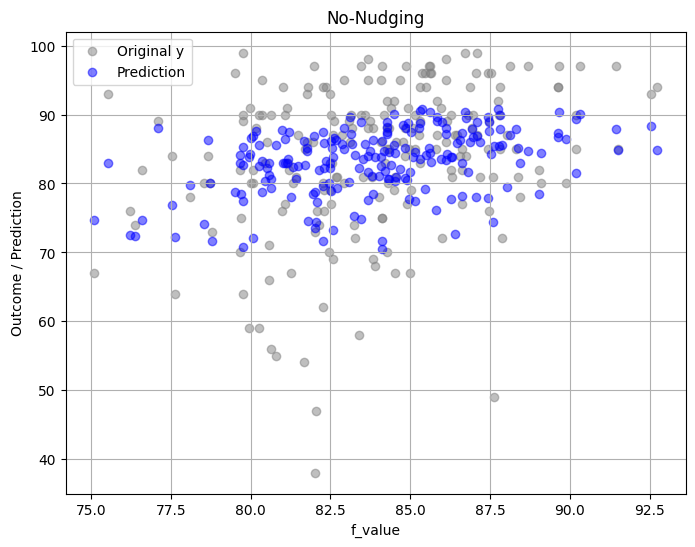

In [159]:
results_non, y_non, final_model_non, f_values_his_non, pred_history_non = no_nudging_iteration(X, y,X_states, n_rounds=1, n_splits=5, plot_each_round=True)

In [208]:
individual

[np.float64(72.40874723679578),
 np.float64(72.87310908540955),
 np.float64(73.07659331107054),
 np.float64(73.7408749891442),
 np.float64(74.12967719852057),
 np.float64(75.54696017677087),
 np.float64(75.5707479579451),
 np.float64(75.57146912892772),
 np.float64(76.6848158159635),
 np.float64(77.9177468357424),
 np.float64(79.31286928717934),
 np.float64(79.6048881229446),
 np.float64(80.90383519917613),
 np.float64(83.04738474861674),
 np.float64(80.26588250460189),
 np.float64(81.31451983171864),
 np.float64(80.10192664143007),
 np.float64(78.19552393261388),
 np.float64(80.80009498529714),
 np.float64(79.1536132899895)]

In [209]:
add_memo_history

[0      26
 1      52
 2      26
 3      35
 4      31
        ..
 199    11
 200    13
 201    10
 202    11
 203    12
 Name: ADD MEMO, Length: 204, dtype: int64,
 0      21
 1      62
 2      21
 3      42
 4      37
        ..
 199     9
 200    10
 201     8
 202    13
 203    14
 Name: ADD MEMO, Length: 204, dtype: int64,
 0      17
 1      74
 2      17
 3      50
 4      44
        ..
 199     7
 200     8
 201     6
 202    16
 203    17
 Name: ADD MEMO, Length: 204, dtype: int64,
 0      14
 1      89
 2      14
 3      60
 4      53
        ..
 199     6
 200     6
 201     5
 202    19
 203    20
 Name: ADD MEMO, Length: 204, dtype: int64,
 0       11
 1      107
 2       11
 3       72
 4       64
       ... 
 199      5
 200      5
 201      4
 202     23
 203     24
 Name: ADD MEMO, Length: 204, dtype: int64,
 0        9
 1      128
 2        9
 3       86
 4       77
       ... 
 199      4
 200      4
 201      3
 202     28
 203     29
 Name: ADD MEMO, Length: 204, dt

In [243]:
results = pd.DataFrame(results)
results['true_mean'] = y.mean()
results

,round,cv_rmse,mean_dist_nudge,mean_dist_true,mean_current_y,mean_all_preds,true_mean
0,1,10.290201,7.889766,7.749951,79.857490,83.164804,83.892157
1,2,10.058196,7.152386,8.920081,81.970511,80.410940,83.892157
2,3,9.370818,6.501099,8.239638,79.753368,81.744184,83.892157
3,4,9.558533,6.076357,8.790510,82.017267,80.863855,83.892157
4,5,10.202513,6.058197,8.479405,79.893650,81.748059,83.892157
5,6,8.741888,6.445121,9.207071,81.522283,80.792358,83.892157
6,7,10.122054,6.126707,9.290489,79.399829,81.069808,83.892157
7,8,10.027426,6.188715,9.716909,80.180500,80.182165,83.892157
8,9,10.358751,6.584720,9.796856,78.075736,79.756550,83.892157
9,10,11.619010,6.182041,10.256768,79.063723,78.971253,83.892157


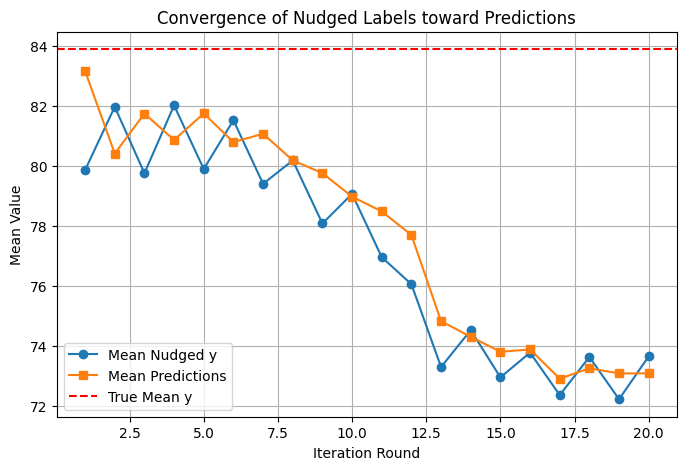

In [244]:
plt.figure(figsize=(8,5))
plt.plot(results["round"], results["mean_current_y"], marker="o", label="Mean Nudged y")
plt.plot(results["round"], results["mean_all_preds"], marker="s", label="Mean Predictions")
plt.axhline(y=results['true_mean'].iloc[0], color='r', linestyle='--', label="True Mean y")

plt.xlabel("Iteration Round")
plt.ylabel("Mean Value")
plt.title("Convergence of Nudged Labels toward Predictions")
plt.legend()
plt.grid(True)
plt.show()

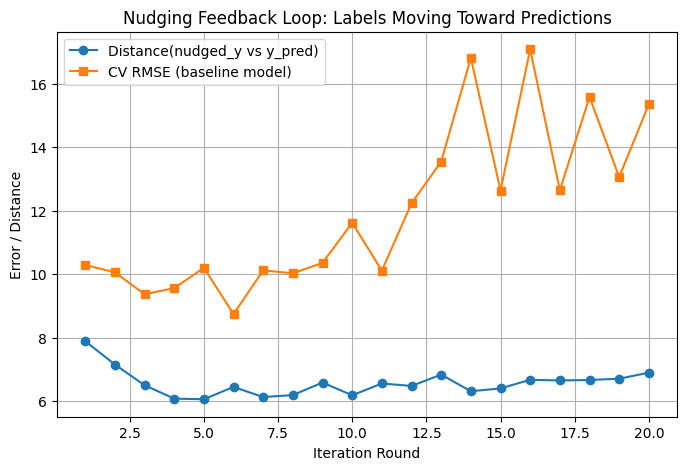

In [245]:
import matplotlib.pyplot as plt
import pandas as pd

df_results = pd.DataFrame(results)

plt.figure(figsize=(8,5))
plt.plot(df_results["round"], df_results["mean_dist_nudge"], marker="o", label="Distance(nudged_y vs y_pred)")
plt.plot(df_results["round"], df_results["cv_rmse"], marker="s", label="CV RMSE (baseline model)")

plt.xlabel("Iteration Round")
plt.ylabel("Error / Distance")
plt.title("Nudging Feedback Loop: Labels Moving Toward Predictions")
plt.legend()
plt.grid(True)
plt.show()


In [237]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

def animate_nudging_single(y, nudged_history, pred_history, attribute_history, save_path=None):
    """
    Animate nudging over iterations for a single attribute.
    - y: ground truth labels
    - nudged_history: list of nudged y across iterations
    - pred_history: list of predicted y across iterations
    - attribute: DataFrame containing the single attribute used for nudging
    """
    fig, ax = plt.subplots(figsize=(7, 6))
    
    # prepare x-axis
    # attribute = attribute[attr_name].values.ravel()
    
    # calculate global ranges across all frames
    all_y_values = np.concatenate([
        np.asarray(y).ravel(),
        np.concatenate([np.asarray(p).ravel() for p in pred_history]),
        np.concatenate([np.asarray(n).ravel() for n in nudged_history])
    ])

    
    ax.set_xlim(0, 150)
    ax.set_ylim(40, 100)
    
    # initial scatter
    scat_true  = ax.scatter(attribute_history[0], y, color="grey", alpha=0.5, label="Original y")
    scat_nudge = ax.scatter(attribute_history[0], nudged_history[0], color="red", alpha=0.5, label="Nudged y")
    scat_pred  = ax.scatter(attribute_history[0], pred_history[0], color="blue", alpha=0.5, label="Prediction")
    # scat_nudge = ax.scatter(attribute_history[0], nudged_history[0], color="red", alpha=0.5, label="Nudged y")
    ax.legend()
    
    ax.set_xlabel("ADD MEMO")
    ax.set_ylabel("Score")
    ax.set_autoscale_on(False)

    # update function
    def update(frame):
        ax.set_title(f"Nudging Iteration {frame+1}")
        preds  = np.asarray(pred_history[frame]).ravel()
        nudged = np.asarray(nudged_history[frame]).ravel()
        attr   = np.asarray(attribute_history[frame]).ravel()
        
        scat_pred.set_offsets(np.c_[attr, preds])
        scat_nudge.set_offsets(np.c_[attr, nudged])
        ax.set_title(f"Nudging Iteration {frame+1}")
        return scat_pred, scat_nudge

    ani = animation.FuncAnimation(
        fig, update, frames=len(nudged_history), interval=1000, blit=True
    )

    if save_path:
        ani.save(save_path, writer="pillow" if save_path.endswith(".gif") else "ffmpeg")
    else:
        plt.show()


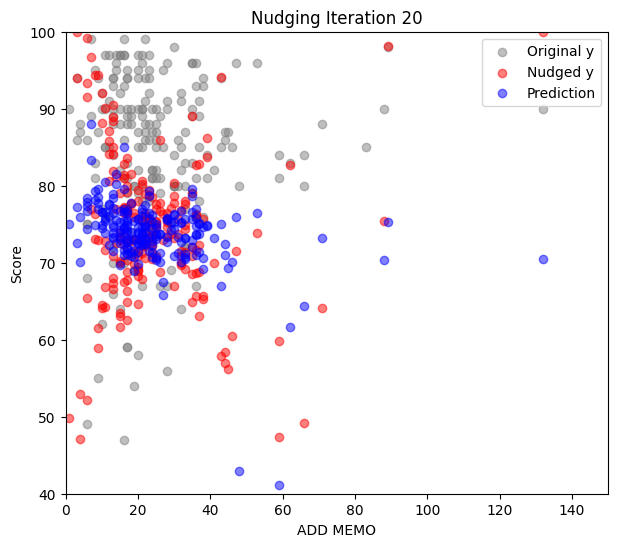

In [246]:
animate_nudging_single(y, nudged_history, pred_history, behavior_his, save_path="ADD_MEMO_animation.gif")

## Few Individual

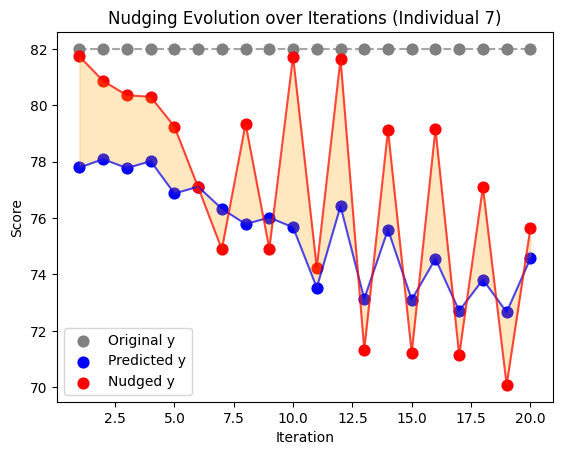

In [232]:
import matplotlib.pyplot as plt

selected_idx = 7
n_rounds = len(pred_history)
x_iter = range(1, n_rounds + 1)

# individual scores in prediction, nudged, original over iterations
orig_score = [y[selected_idx]] * n_rounds
pred_scores = [pred_history[t][selected_idx] for t in range(n_rounds)]
nudged_scores = [nudged_history[t][selected_idx] for t in range(n_rounds)]

    
# 繪圖
plt.scatter(x_iter, orig_score, color='grey', s=60, label='Original y')
plt.scatter(x_iter, pred_scores, color='blue', s=60, label='Predicted y')
plt.scatter(x_iter, nudged_scores, color='red', s=60, label='Nudged y')
plt.plot(x_iter, orig_score, color='grey', linestyle='--', alpha=0.7)
plt.plot(x_iter, pred_scores, color='blue', linestyle='-', alpha=0.7)
plt.plot(x_iter, nudged_scores, color='red', linestyle='-', alpha=0.7)

plt.fill_between(x_iter, pred_scores, nudged_scores, 
                 color='orange', alpha=0.25)

plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title(f"Nudging Evolution over Iterations (Individual {selected_idx})")
plt.legend()
plt.grid(False)
plt.show()
